<h1>Capstone Project - Recommending Neighborhoods in Toronto</h1>


<h2>Problem Statement</h2>

Analyze Toronto location data and recommend top neighborhoods that match customer expectation.


<h2>Background</h2>

One of the tough questions when people moving into a new city is which neighborhood is best? In this project, I would like to create a hypothetical business scenario to analyze Toronto location data and recommend top neighborhoods that best match customer expectation.

<h2>Data</h2>

1)Use raw data provided by Wikipedia,<br> 
2)Geographical coordinates from https://cocl.us/Geospatial_data<br>
3)Location data from FourSquare <br>

Wikipedia dataset contains a list of Canadian postal codes. I will retreive it by scraping a table from the website. I will use this dataset to create a geographical segmentation of Toronto based on postal code, and link it to coordinates.

<h2>The Python Code</h2>

In [1]:
!pip install bs4
!pip install lxml

  Stored in directory: /home/dsxuser/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4


In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from urllib.request import urlopen
import urllib.request
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium
print ("folium has been installed")

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

<b>Obtain postal codes of Canada from wikipedia and perform data wrangling.</b><br>
Postal codes beginning with M are located within the city of Toronto in the province of Ontario

In [3]:
#Read the Wikipedia article and save to local copy
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
request = urllib.request.urlopen(url)
wiki_article = request.read().decode()
print ("Connected to ", url)

with open('List_of_postal_codes_of_Canada:_M.html', 'w') as fo:
    fo.write(wiki_article)
print ("Read _M.html into wiki_article");
       
#Use BeautifulSoup API html.parser to parse the html, read into tables
wiki_article = open('List_of_postal_codes_of_Canada:_M.html').read()
soup = BeautifulSoup(wiki_article, 'html.parser')
tables = soup.find_all('table', class_='sortable')
print("parsed wiki_article into tables.");

# Loop through tables and identify header table
for table in tables:
    all_tables = table.find_all('th')
    header = [th.text.strip() for th in all_tables]
    if header[:5] == ['Postcode', 'Borough', 'Neighborhood']:
        break
print("Found table containing Postcode, Borough, Neighborhood");
      
# Extract Postcode, Borough, Neighborhood and write to semicolon-delimited file.
with open('List_of_postal_codes_of_Canada:_M.txt', 'w') as fo:
    for tr in table.find_all('tr'):
        tds = tr.find_all('td')
        if not tds:
            continue
        Postcode, Borough, Neighborhood = [td.text.strip() for td in tds[:4]]
        
        print('; '.join([Postcode, Borough, Neighborhood]), file=fo)
print ("complete extracting Postcode, Borough, Neighborhood data into semicolon-delimited file")

Connected to  https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
Read _M.html into wiki_article
parsed wiki_article into tables.
Found table containing Postcode, Borough, Neighborhood
complete extracting Postcode, Borough, Neighborhood data into semicolon-delimited file


In [4]:
# Load the Postcode, Borough, Neighborhood data into pandas dataframe        
df = pd.read_table('List_of_postal_codes_of_Canada:_M.txt', delimiter = ';', header = None)
df.columns = ['PostCode', 'Borough', 'Neighborhood']

# Ignore not assigned borough
df1 = df[df['Borough'] != ' Not assigned']
df1.reset_index(inplace = True, drop = True)

# Assign borough value to neighborhood if the neighborhood is not assigned.
position = 0
neigh_list = []
for i,j in zip(df1['Borough'], df1['Neighborhood']):
    if j == ' Not assigned':
        neigh_list.append(i)
    else:
        neigh_list.append(j)

post_list = df1['PostCode'].tolist()
br_list = df1['Borough'].tolist()

df1 = pd.DataFrame([post_list, br_list, neigh_list]).T
df1.columns = ['PostCode', 'Borough', 'Neighborhood']
print ("df1 data")
df1.head()

df1 data


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  from ipykernel import kernelapp as app


,PostCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [5]:
# Group dataframe by PostCode and combine neighborhood values.
borough_list =[] 
Neighborhood_list = []

for item in df1['Borough']:
    item_new = str(item)[1:] + ':'
    borough_list.append(item_new)
#borough_list

In [6]:
for item in df1['Neighborhood']:
    item_new = str(item)[1:] + ':'
    Neighborhood_list.append(item_new)
#Neighborhood_list

In [7]:
PostCode_list = df1['PostCode'].tolist()

df2 = pd.DataFrame([PostCode_list, borough_list, Neighborhood_list]).T
df2.columns = ['PostCode', 'Borough', 'Neighborhood']
df2.head()

,PostCode,Borough,Neighborhood
0,M3A,North York:,Parkwoods:
1,M4A,North York:,Victoria Village:
2,M5A,Downtown Toronto:,Harbourfront:
3,M6A,North York:,Lawrence Heights:
4,M6A,North York:,Lawrence Manor:


In [8]:
new_df = df2.groupby('PostCode').sum()
new_df.head()

,Borough,Neighborhood
PostCode,,
M1B,Scarborough:Scarborough:,Rouge:Malvern:
M1C,Scarborough:Scarborough:Scarborough:,Highland Creek:Rouge Hill:Port Union:
M1E,Scarborough:Scarborough:Scarborough:,Guildwood:Morningside:West Hill:
M1G,Scarborough:,Woburn:
M1H,Scarborough:,Cedarbrae:


In [9]:
borough_list=[]
Neighborhood_list = []
PostCode_list = new_df.index.tolist()

for item in new_df['Borough']:
    item_new = np.unique(np.array(str(item).split(':')))[1]
    borough_list.append(item_new)

for item in new_df['Neighborhood']:
    item_new = str(np.array(str(item).split(':'))[:-1].tolist())[1:][:-1].replace("'","")
    Neighborhood_list.append(item_new)

df3 = pd.DataFrame([PostCode_list, borough_list, Neighborhood_list]).T
df3.columns = ['PostCode', 'Borough', 'Neighborhood']
df3.head()

,PostCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


<b>Geographical coordinates</b><br>
Geospatial_data contains postal code coordinates. We will link postal code with coordinates.

In [10]:
# Load the csv file from source.
df_co = pd.read_csv('https://cocl.us/Geospatial_data')
print ("Read https://cocl.us/Geospatial_data csv file into data frame")

lat_list = []
long_list = []

#Extract latitude and longitude for postal codes
for PostCode_target in df3['PostCode']:
    for PostCode, Latitude, Longitude in zip (df_co['Postal Code'],
                                                 df_co['Latitude'],
                                               df_co['Longitude']):
        if PostCode_target == PostCode:
            lat_list.append(Latitude)
            long_list.append(Longitude)
print ("Extracted latitude and longitude for postal codes");

# Add coordinates information to the pandas dataframe.
toronto_data = pd.DataFrame([df3['PostCode'].tolist(), 
                         df3['Borough'].tolist(), 
                         df3['Neighborhood'].tolist(),
                         lat_list,
                         long_list]).T
toronto_data.columns = ['PostCode','Borough','Neighborhood', 'Latitude', 'Longitude']
print("toronto_data", toronto_data.shape)
toronto_data.head()

Read https://cocl.us/Geospatial_data csv file into data frame
Extracted latitude and longitude for postal codes
toronto_data (103, 5)


,PostCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.8067,-79.1944
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.7845,-79.1605
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7636,-79.1887
3,M1G,Scarborough,Woburn,43.771,-79.2169
4,M1H,Scarborough,Cedarbrae,43.7731,-79.2395


In [11]:
import requests # library to handle requests

import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library

In [12]:
# Extract latitude and longitude of downtown Toronto
df_to = toronto_data
latitude = toronto_data[toronto_data['Borough']=='Downtown Toronto'].iloc[0].Latitude
longitude = toronto_data[toronto_data['Borough']=='Downtown Toronto'].iloc[0].Longitude

print('The geograpical coordinates of Downtown Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Downtown Toronto City are 43.6795626, -79.37752940000001.


In [13]:
# create map of Toronto using latitude and longitude values.
map_to = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, postcode in zip(df_to['Latitude'], df_to['Longitude'], df_to['Borough'], 
                                           df_to['PostCode']):
    label = '{}, {}'.format(postcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_to)  
    
map_to

In [14]:
from pandas.io.json import json_normalize

# Enter the following information. The actual info was removed before sharing since it is sensitive. please see output.
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200112' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 300 # define radius

neighborhood_latitude = df_to[df_to['PostCode']=='M5C'].Latitude.iloc[0]
neighborhood_longitude = df_to[df_to['PostCode']=='M5C'].Longitude.iloc[0]

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# Retrieve information from FourSquare
print ("Connect to Foursquare:", url)
results = requests.get(url).json()
print ("request completed")

Connect to Foursquare: https://api.foursquare.com/v2/venues/explore?&client_id=R2YHPSY0J0CT1XROQ34B1AIUKC1YYVRGDNNMRFLW43KCTXLP&client_secret=3IP5352RXEMEB3RQSY5LITH51FDMOSX4YOEWRDUCLIGSUFUX&v=20200112&ll=43.6514939,-79.3754179&radius=300&limit=100
request completed


In [15]:
# Function for getting nearby venues by names, latitudes and longtitudes within a radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):     
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])    
    nearby_venues.columns = ['PostCode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']        
    return(nearby_venues)

In [16]:
#Get nearby venues for all data in df_to
print ("Calling getNearbyVenues")
to_venues = getNearbyVenues(names=df_to['PostCode'],
                                   latitudes=df_to['Latitude'],
                                   longitudes=df_to['Longitude'])
print ("Complete getNearbyVenues")
to_venues.head()

Calling getNearbyVenues
Complete getNearbyVenues


,PostCode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,M1C,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,M1E,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,M1E,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,M1E,43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


In [17]:
# one hot encoding
to_onehot = pd.get_dummies(to_venues[['Venue Category']], prefix="", prefix_sep="")

# add postcal code column back to dataframe
to_onehot['PostCode'] = to_venues['PostCode'] 

# move postal code column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

to_onehot.head()

,PostCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
#Group rows by PostCode and take the mean of the frequency of occurrence of each category
postcode_venues_grouped = to_onehot.groupby('PostCode').mean().reset_index()
postcode_venues_grouped.tail(10)

,PostCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
88,M8X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
89,M8Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
90,M8Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.066667,0.0,0.0
91,M9C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
92,M9L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
93,M9M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
94,M9P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
95,M9R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
96,M9V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
97,M9W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [103]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each postal code.

In [104]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# instantiate a new dataframe
postcode_venues_sorted = pd.DataFrame(columns=columns)
postcode_venues_sorted['PostCode'] = postcode_venues_grouped['PostCode']

for ind in np.arange(postcode_venues_grouped.shape[0]):
    postcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(postcode_venues_grouped.iloc[ind, :], num_top_venues)

postcode_venues_sorted.head()

,PostCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Fast Food Restaurant,Yoga Studio,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant
1,M1C,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field
2,M1E,Rental Car Location,Intersection,Breakfast Spot,Spa,Pizza Place,Mexican Restaurant,Electronics Store,Medical Center,Dog Run,Doner Restaurant
3,M1G,Coffee Shop,Korean Restaurant,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant
4,M1H,Hakka Restaurant,Bakery,Fried Chicken Joint,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bank,Lounge,Electronics Store


<h2>Cluster Postal Codes</h2>

Run k-means to cluster the neighborhood into 5 clusters.

In [105]:
# set number of clusters
toronto_grouped = postcode_venues_grouped
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('PostCode', 1)

# import k-means from clustering stage
from sklearn.cluster import KMeans

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [106]:
kmeans.labels_.shape

(98,)

In [107]:
postcode_venues_sorted.shape

(98, 11)

In [108]:
# add clustering labels
postcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

postcode_venues_sorted.head()

,Cluster Labels,PostCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,M1B,Fast Food Restaurant,Yoga Studio,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant
1,1,M1C,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field
2,1,M1E,Rental Car Location,Intersection,Breakfast Spot,Spa,Pizza Place,Mexican Restaurant,Electronics Store,Medical Center,Dog Run,Doner Restaurant
3,1,M1G,Coffee Shop,Korean Restaurant,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant
4,1,M1H,Hakka Restaurant,Bakery,Fried Chicken Joint,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bank,Lounge,Electronics Store


In [109]:
#Merge original toronto data (including borough and neighborhood, latitude, longtitude) with venues and label data
toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#toronto_merged = toronto_merged.join(postcode_venues_sorted.set_index('PostCode'), on='PostCode')

#toronto_merged.head() # check the last columns!

postcode_venues_sorted.set_index('PostCode')

toronto_merged = pd.merge(toronto_data, postcode_venues_sorted, on='PostCode')

print (toronto_merged.shape)
toronto_merged.head()

(98, 16)


,PostCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.8067,-79.1944,1,Fast Food Restaurant,Yoga Studio,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.7845,-79.1605,1,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7636,-79.1887,1,Rental Car Location,Intersection,Breakfast Spot,Spa,Pizza Place,Mexican Restaurant,Electronics Store,Medical Center,Dog Run,Doner Restaurant
3,M1G,Scarborough,Woburn,43.771,-79.2169,1,Coffee Shop,Korean Restaurant,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant
4,M1H,Scarborough,Cedarbrae,43.7731,-79.2395,1,Hakka Restaurant,Bakery,Fried Chicken Joint,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bank,Lounge,Electronics Store


<h3>Finally, let's visualize the resulting clusters</h3>

In [112]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [113]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3>Examine Clusters</h3>

Now, let's examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster. 

<h4>Cluster 1</h4>

In [144]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].head()

,PostCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,M1J,Scarborough,Scarborough Village,43.7447,-79.2395,0,Playground,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
14,M1V,Scarborough,"Agincourt North, ""LAmoreaux East"", Milliken, S...",43.8153,-79.2846,0,Park,Playground,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
21,M2P,North York,York Mills West,43.7528,-79.4,0,Park,Bank,Convenience Store,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
23,M3A,North York,Parkwoods,43.7533,-79.3297,0,Food & Drink Shop,Park,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Yoga Studio
28,M3K,North York,"CFB Toronto, Downsview East",43.7375,-79.4648,0,Park,Airport,Snack Place,Comfort Food Restaurant,Comic Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


<h4>Cluster 2</h4>

In [115]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1].head()

,PostCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.8067,-79.1944,1,Fast Food Restaurant,Yoga Studio,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.7845,-79.1605,1,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7636,-79.1887,1,Rental Car Location,Intersection,Breakfast Spot,Spa,Pizza Place,Mexican Restaurant,Electronics Store,Medical Center,Dog Run,Doner Restaurant
3,M1G,Scarborough,Woburn,43.771,-79.2169,1,Coffee Shop,Korean Restaurant,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant
4,M1H,Scarborough,Cedarbrae,43.7731,-79.2395,1,Hakka Restaurant,Bakery,Fried Chicken Joint,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bank,Lounge,Electronics Store


<h4>Cluster 3</h4>

In [116]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2].head()

,PostCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
89,M8Y,Etobicoke,"Humber Bay, ""Kings Mill Park"", Kingsway Park S...",43.6363,-79.4985,2,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field
93,M9M,North York,"Emery, Humberlea",43.7248,-79.5322,2,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field


Create data frame by cluster

In [117]:
postcode_labels = postcode_venues_sorted[["PostCode", "Cluster Labels"]]
postcode_labels.set_index('PostCode')

clusters_merged = pd.merge(postcode_labels, postcode_venues_grouped, on='PostCode')
clusters_merged.drop(["PostCode"], axis=1, inplace=True)
clusters_merged.head()

,Cluster Labels,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
cluster_grouped = clusters_merged.groupby('Cluster Labels').mean().reset_index()
cluster_grouped.head()

,Cluster Labels,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0.000000,0.000000,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014286,0.000000
1,1,0.000871,0.000151,0.000717,0.000717,0.000717,0.001435,0.002152,0.001435,0.012285,...,0.003385,0.000645,0.003521,0.005459,0.000678,0.001403,0.000868,0.000998,0.002356,0.003667
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [169]:
#prepare data for each cluster
cluster1 = pd.DataFrame(cluster_grouped.iloc[0][1:]).reset_index()
cluster1.columns=['VenueCategory','Count']
cluster1.sort_values(by="Count", ascending=False, inplace=True)
cluster1_toplist = cluster1[0:10]
cluster1_toplist.set_index('VenueCategory', inplace=True)
cluster1_toplist.head()

,Count
VenueCategory,
Park,0.317857
Playground,0.139286
Trail,0.050000
Convenience Store,0.038095
Food & Drink Shop,0.035714


In [171]:
cluster2 = pd.DataFrame(cluster_grouped.iloc[1][1:]).reset_index()
cluster2.columns=['VenueCategory','Count']
cluster2.sort_values(by="Count", ascending=False, inplace=True)
cluster2_toplist = cluster2[0:10]
cluster2_toplist.set_index('VenueCategory', inplace=True)
cluster2_toplist.head()

,Count
VenueCategory,
Coffee Shop,0.066708
Pizza Place,0.042482
Café,0.035706
Fast Food Restaurant,0.029717
Bar,0.026850


In [173]:
cluster3 = pd.DataFrame(cluster_grouped.iloc[2][1:]).reset_index()
cluster3.columns=['VenueCategory','Count']
cluster3.sort_values(by="Count", ascending=False, inplace=True)
cluster3_toplist = cluster3[0:10]
cluster3_toplist.set_index('VenueCategory', inplace=True)
cluster3_toplist.head()

,Count
VenueCategory,
Baseball Field,1.0
Accessories Store,0.0
Mexican Restaurant,0.0
Molecular Gastronomy Restaurant,0.0
Modern European Restaurant,0.0


In [181]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

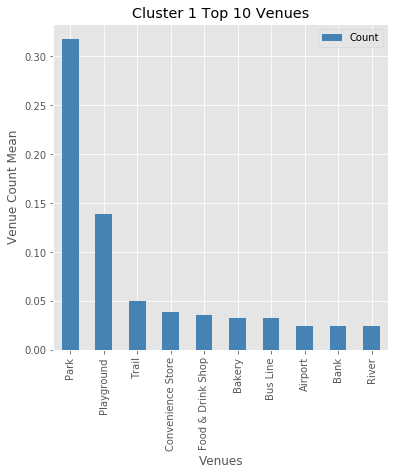

In [182]:
# generate plot
cluster1_toplist.plot(kind='bar', figsize=(6, 6), color='steelblue')
plt.xlabel('Venues')
plt.ylabel('Venue Count Mean')
plt.title('Cluster 1 Top 10 Venues')

plt.show()

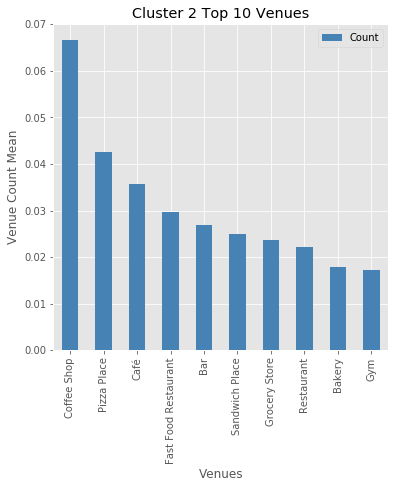

In [176]:
# generate plot
cluster2_toplist.plot(kind='bar', figsize=(6, 6), color='steelblue')
plt.xlabel('Venues')
plt.ylabel('Venue Count Mean')
plt.title('Cluster 2 Top 10 Venues')

plt.show()

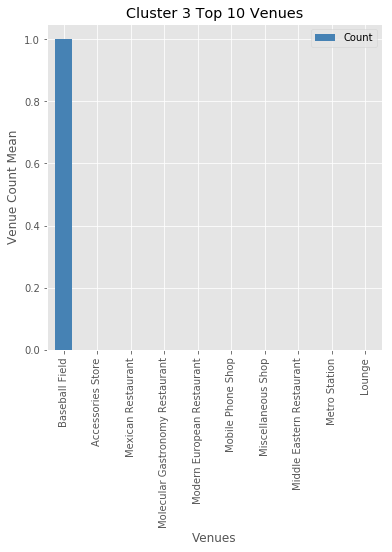

In [177]:
# generate plot
cluster3_toplist.plot(kind='bar', figsize=(6, 6), color='steelblue')
plt.xlabel('Venues')
plt.ylabel('Venue Count Mean')
plt.title('Cluster 3 Top 10 Venues')

plt.show()